In [15]:
%run "00_setup_paths_and_imports.py"

# choose the same region name you used in 01_regions_and_time
region_name = "coast" # options: "coast", "mike_station"

# load the config saved by 01_regions_and_time.ipynb
config = np.load(DATA_INTERIM / f"config_{region_name}.npy", allow_pickle=True).item()

region      = config["region"]
centers     = config["centers"]

# unpack lat/lon from region dict 
lat_min = region["lat_min"]
lat_max = region["lat_max"]
lon_min = region["lon_min"]
lon_max = region["lon_max"]

In [16]:
# ------------------------------------------------------------------
# 2. Load MLD and compute area-mean + map
# ------------------------------------------------------------------
mld_nc = DATA_RAW / f"cmems_mld_{region_name}.nc"
mld_ds = xr.open_dataset(mld_nc)

# area-average MLD over region
mld_area = mld_ds["mlotst"].mean(dim=["latitude", "longitude"], skipna=True)

# ensure time is a proper datetime index (naive OK here)
mld_area = mld_area.assign_coords(
    time=pd.to_datetime(mld_area["time"].values)
)

In [17]:
# ------------------------------------------------------------------
# 3. Load bathymetry and make the 2-panel map
# ------------------------------------------------------------------
bathy_nc = DATA_RAW / f"cmems_bathy_{region_name}.nc"
bathy_ds = xr.open_dataset(bathy_nc)

depth = bathy_ds["model_depth"].where(bathy_ds["model_depth"] > 0)

In [18]:
# ------------------------------------------------------------------
# 4. Compute static h1/h2 and save as arrays
# ------------------------------------------------------------------
H_median = float(depth.median(skipna=True))
print(f"H median ≈ {H_median:.1f} m")

h1_variable = mld_area.interp(time=centers).to_numpy()  # m
h2_variable = H_median - h1_variable

delta_z_variable = 0.5*h1_variable + 0.5*h2_variable

np.savez(
    DATA_INTERIM / f"layers_variable_{region_name}.npz",
    h1=h1_variable,
    h2=h2_variable,
    H=H_median,
    delta_z=delta_z_variable,
)
print("Saved variable MLD layers to", DATA_INTERIM / f"layers_variable_{region_name}.npz")

H median ≈ 224.7 m
Saved variable MLD layers to C:\Users\siebert\Documents\Projekte\SEAO2CDR\rIAM\data\interim\layers_variable_coast.npz


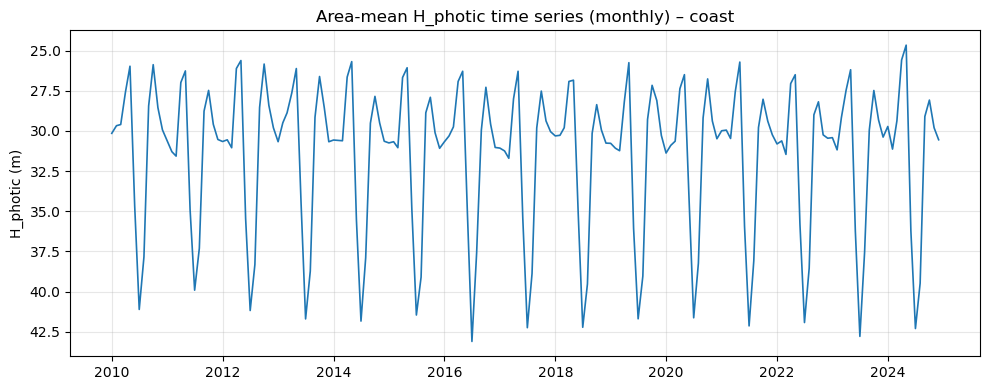

In [19]:
# ------------------------------------------------------------------
# EXKURSUS: Photictic depth time series
# ------------------------------------------------------------------
photic_nc = DATA_RAW / f"cmems_photic_{region_name}.nc"
photic_ds = xr.open_dataset(photic_nc)

photic_surf = photic_ds["kd"].sel(depth=0)


photic_area = photic_surf.mean(dim=["latitude", "longitude"], skipna=True)

H_photic = 4.6 / photic_area

plt.figure(figsize=(10, 4))
plt.plot(
    H_photic["time"].values,
    H_photic.values,
    lw=1.2,
)
plt.gca().invert_yaxis()  # optional
plt.grid(alpha=0.3)
plt.ylabel("H_photic (m)")
plt.title(f"Area-mean H_photic time series (monthly) – {region_name}")
plt.tight_layout()
plt.savefig(IMG_DIR / f"H_photic_monthly_{region_name}.png", dpi=300)
plt.show()


In [20]:
h1_photic = H_photic.interp(time=centers).to_numpy()
h2_photic = H_median - h1_photic
delta_z_photic = 0.5*h1_photic + 0.5*h2_photic

np.savez(
    DATA_INTERIM / f"layers_photic_{region_name}.npz",
    h1=h1_photic,
    h2=h2_photic,
    H=H_median,
    delta_z=delta_z_photic,
)
print("Saved variable MLD layers to", DATA_INTERIM / f"layers_photic_{region_name}.npz")

Saved variable MLD layers to C:\Users\siebert\Documents\Projekte\SEAO2CDR\rIAM\data\interim\layers_photic_coast.npz
